# Learning the shape of manifold from the code generated from celluation from that manifold

## Data generation

### 1. How to generate the stabilizer generators of a code and store them

The stabilizer generators themselves are stored in two matrices $H_z$ and $H_x$, which operate over the field of $\mathbb{F}_2$ 

So, the first step is to code up a class which constructs these matrices for the toric code

In [14]:
from panqec.codes.surface_2d import Toric2DCode

In [15]:
code = Toric2DCode(2) # takes in size as an argument

In [16]:
code.Hx.todense() # this is the x parity check matrix

matrix([[1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 0, 0, 0, 1, 0, 1],
        [0, 0, 1, 1, 1, 0, 1, 0],
        [0, 0, 1, 1, 0, 1, 0, 1]], dtype=uint8)

In [17]:
code.Hz.todense() # this is the z parity check matrix 

matrix([[1, 0, 1, 0, 1, 1, 0, 0],
        [0, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 0, 0, 1, 1],
        [0, 1, 0, 1, 0, 0, 1, 1]], dtype=uint8)

In [18]:
code.n # this is the number of qubits, i.e. the number of columns of Hx and Hz

8

In [19]:
code.n_stabilizers # this is the number of stabilizers, i.e. the number of rows of Hx and Hz

8

In [20]:
code.k # this is the number of logical qubits encoded, in this case 2, because the torus has two non-trivial homotopic classes

2

In [21]:
code.d # this is the distance, not really relevant here, but just for completeness

2

So, essentially, we want to use the following two quantities, which coincides with the boundary maps $\partial_1$ and $\partial_2$

$$ C_2 \xrightarrow[]{\partial_2} C_1 \xrightarrow[]{\partial_1}  C_0$$

This is $\partial_2$

In [22]:
hx = code.Hx.toarray() 

and this is the transpose of $\partial_1$

In [23]:
hz = code.Hz.toarray() 

In [24]:
hx

array([[1, 1, 0, 0, 1, 0, 1, 0],
       [1, 1, 0, 0, 0, 1, 0, 1],
       [0, 0, 1, 1, 1, 0, 1, 0],
       [0, 0, 1, 1, 0, 1, 0, 1]], dtype=uint8)

In [25]:
hz.T

array([[1, 0, 1, 0],
       [0, 1, 0, 1],
       [1, 0, 1, 0],
       [0, 1, 0, 1],
       [1, 1, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 1, 1],
       [0, 0, 1, 1]], dtype=uint8)

they are both written in a particular basis for the chain complex, and from basic linear algebra, this basis has dimension 8, which is exactly the number of qubits, and the boundary maps induce a subspace, that we would call the "codespace", on which we perform error correction

So, I guess this is a good starting point for generating the boundary maps. We can always choose different bases to generate different boundary maps that would give us the same "codespace". The topology of the "codespace" should be independent of the choice of basis, which is a good sanity check for our procedure, or could be used for just generating more data.

### 2. How to get from the Hx and Hz matrices to a persistent diagram? 

My current take is to interpret the matrices as hypergraphs, with a built-in simplicial complex structure, on which we will be able to perform a hypergraph Laplacian. The hypergraph Laplacian will be a unambiguous way to build a filtration to get our TDA going.

### 3. Using topological sort to generate a simplicial stream from a chain complex

### 4. Doing TDA on a simplicial stream 

In [2]:
import gudhi as gd

In [3]:
# Create a Simplex Tree
st = gd.SimplexTree()

In [4]:
# Assume simplicial_stream is your input simplicial stream.
# Here, you should add simplices to the simplex tree.
# For example, adding some simplices manually:
st.insert([0])
st.insert([1])
st.insert([0, 1])
st.insert([2])
st.insert([1, 2])
st.insert([0, 2])
st.insert([0, 1, 2])

True

In [5]:
st.dimension()

2

In [6]:
st.num_simplices()

7

In [7]:
st.num_vertices()

3

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

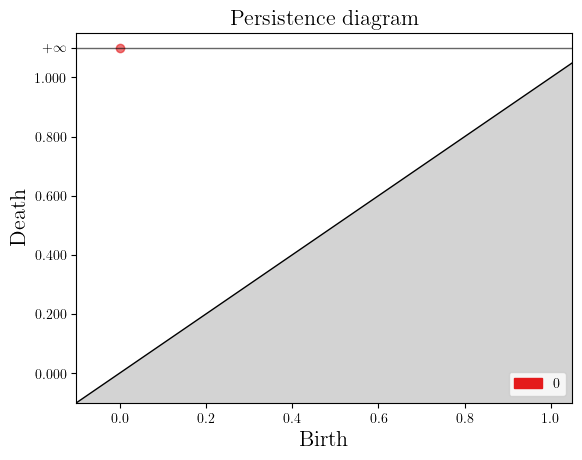

In [8]:
# Insert your simplicial stream here
# for simplex in simplicial_stream:
#     st.insert(simplex)

# Compute persistence
diag = st.persistence()

# Plotting the persistence diagram
gd.plot_persistence_diagram(diag)

In [9]:
st.betti_numbers()

[1, 0]

In [40]:
def build_simplex_tree_from_boundary_matrices(boundary_matrices):
    st = gd.SimplexTree()

    # Add vertices
    for vertex in range(len(boundary_matrices[0][0])):
        st.insert([vertex])

    # Add higher dimensional simplices
    for dim, boundary_matrix in enumerate(boundary_matrices):
        for simplex_index, row in enumerate(boundary_matrix):
            # Create a simplex as a list of its vertices
            simplex = [vertex for vertex, entry in enumerate(row) if entry != 0]
            simplex.append(simplex_index + len(row))  # Add the current simplex vertex
            st.insert(simplex, filtration=dim)
    print(simplex)
    return st

[2, 3, 11]
[(2, (1.0, inf)), (2, (1.0, inf)), (1, (0.0, inf)), (0, (0.0, inf))]


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

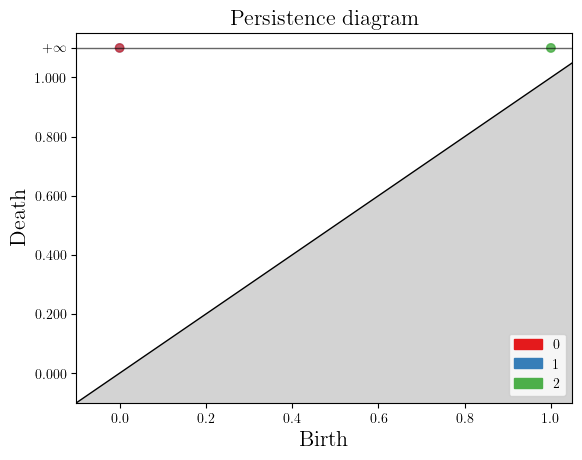

In [41]:
# Example boundary matrices
boundary_matrices = [
    # Boundary matrix for 1-simplices (edges)
    hx,
    # Boundary matrix for 2-simplices (triangles)
    hz.T
    # Add more matrices for higher dimensions if needed
]

# Build the simplex tree
simplex_tree = build_simplex_tree_from_boundary_matrices(boundary_matrices)

# Compute and print persistence
diag = simplex_tree.persistence()
print(diag)

# Optionally, plot the persistence diagram
gd.plot_persistence_diagram(diag)

In [36]:
simplex_gen = simplex_tree.get_simplices()

In [37]:
next(simplex_gen)

([0, 1, 4, 6, 8], 0.0)

In [38]:
next(simplex_gen)

([0, 1, 4, 6], 0.0)

In [39]:
next(simplex_gen)

([0, 1, 4, 8], 0.0)

In [27]:
simplex_tree.betti_numbers()

[1, 1, 2, 0]

In [28]:
simplex_tree.persistent_betti_numbers()

TypeError: persistent_betti_numbers() takes exactly 2 positional arguments (0 given)

In [46]:
boundary_matrices[0][2]

[1, 0, 1]

[0, 2, 4]
[(1, (0.0, inf)), (0, (0.0, inf))]


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

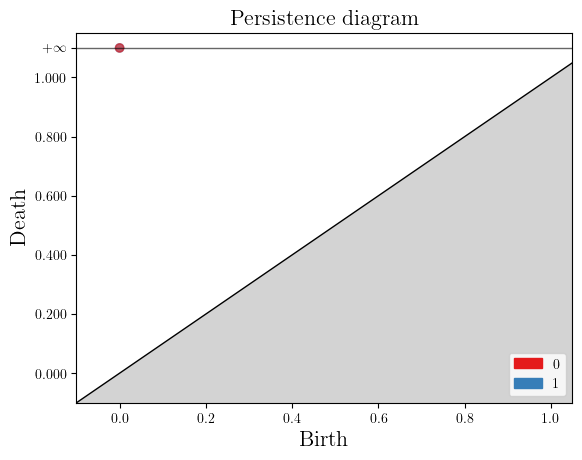

In [43]:
# Example boundary matrices
boundary_matrices = [
    # Boundary matrix for 1-simplices (edges)
     [[1, 1, 0], [0, 1, 1], [1, 0, 1]],
    # Boundary matrix for 2-simplices (triangles)
    [[1, 1, 0], [1, 0, 1]]
    # Add more matrices for higher dimensions if needed
]

# Build the simplex tree
simplex_tree = build_simplex_tree_from_boundary_matrices(boundary_matrices)

# Compute and print persistence
diag = simplex_tree.persistence()
print(diag)

# Optionally, plot the persistence diagram
gd.plot_persistence_diagram(diag)

In [12]:
simplex_tree.betti_numbers()

[1, 1]

In [1]:
import numpy as np
from ldpc import mod2
from ldpc.alist import save_alist
#from ldpc.code_util import compute_code_distance
#from bposd import stab

In [1]:
# Define a class
class DataGen:
    # Constructor (initialize the object)
    def __init__(self, attribute1, attribute2):
        self.attribute1 = attribute1
        self.attribute2 = attribute2

    # Define methods (functions) for the class
    def method1(self):
        return f"Method 1 called with attributes: {self.attribute1} and {self.attribute2}"

    def method2(self, new_value):
        self.attribute1 = new_value

# Create an instance of the class
obj = MyClass("Value 1", "Value 2")

# Access attributes and call methods
print(obj.attribute1)  # Access an attribute
print(obj.method1())   # Call a method

# Modify attributes
obj.method2("New Value")
print(obj.attribute1)  # Attribute updated

# Create another instance of the class
obj2 = MyClass("Another Value", "Another Value 2")

Value 1
Method 1 called with attributes: Value 1 and Value 2
New Value


In [ ]:
class css_code():

    def __init__(self,hx=np.array([[]]),hz=np.array([[]]), name="<Unnamed CSS code>"):

        self.hx=hx #hx pcm
        self.hz=hz #hz pcm

        self.lx=np.array([[]]) #x logicals
        self.lz=np.array([[]]) #z logicals

        self.N=np.nan #block length
        self.K=np.nan #code dimension
        self.D=code_distance #code distance
        self.L=np.nan #max column weight
        self.Q=np.nan #max row weight

        _,nx=self.hx.shape
        _,nz=self.hz.shape
        try:
            assert nx==nz
        except AssertionError:
            raise Exception("Error: hx and hz matrices must have equal numbers of columns!")

        if nx!=0:
            self.compute_dimension()
            self.compute_ldpc_params()
            self.compute_logicals()

        self.name=name

    def compute_dimension(self):

        self.N=self.hx.shape[1]
        assert self.N == self.hz.shape[1], "Code block length (N) inconsistent!"

        self.K=self.N-mod2.rank(self.hx)-mod2.rank(self.hz)
        return self.K

    def compute_ldpc_params(self):

        #column weights
        hx_l=np.max(np.sum(self.hx,axis=0))
        hz_l=np.max(np.sum(self.hz,axis=0))
        self.L=np.max([hx_l,hz_l]).astype(int)

        #row weights
        hx_q=np.max(np.sum(self.hx,axis=1))
        hz_q=np.max(np.sum(self.hz,axis=1))
        self.Q=np.max([hx_q,hz_q]).astype(int)

    def save_sparse(self, code_name):

        self.code_name=code_name

        hx=self.hx
        hz=self.hz
        save_alist(f"{code_name}_hx.alist",hx)
        save_alist(f"{code_name}_hz.alist",hz)

        lx=self.lx
        lz=self.lz
        save_alist(f"{code_name}_lx.alist",lx)
        save_alist(f"{code_name}_lz.alist",lz)

    def to_stab_code(self):

        hx=np.vstack([np.zeros(self.hz.shape,dtype=int),self.hx])
        hz=np.vstack([self.hz,np.zeros(self.hx.shape,dtype=int)])
        return stab.stab_code(hx,hz)

    @property
    def h(self):
        hx=np.vstack([np.zeros(self.hz.shape,dtype=int),self.hx])
        hz=np.vstack([self.hz,np.zeros(self.hx.shape,dtype=int)])
        return np.hstack([hx,hz])

    @property
    def l(self):
        lx=np.vstack([np.zeros(self.lz.shape,dtype=int),self.lx])
        lz=np.vstack([self.lz,np.zeros(self.lx.shape,dtype=int)])
        return np.hstack([lx,lz])


    def compute_logicals(self):

        def compute_lz(hx,hz):
            #lz logical operators
            #lz\in ker{hx} AND \notin Im(Hz.T)

            ker_hx=mod2.nullspace(hx) #compute the kernel basis of hx
            im_hzT=mod2.row_basis(hz) #compute the image basis of hz.T

            #in the below we row reduce to find vectors in kx that are not in the image of hz.T.
            log_stack=np.vstack([im_hzT,ker_hx])
            pivots=mod2.row_echelon(log_stack.T)[3]
            log_op_indices=[i for i in range(im_hzT.shape[0],log_stack.shape[0]) if i in pivots]
            log_ops=log_stack[log_op_indices]
            return log_ops

        if self.K==np.nan: self.compute_dimension()
        self.lx=compute_lz(self.hz,self.hx)
        self.lz=compute_lz(self.hx,self.hz)

        return self.lx,self.lz

    def canonical_logicals(self):
        temp=mod2.inverse(self.lx@self.lz.T %2)
        self.lx=temp@self.lx %2


    @property
    def code_params(self):
        try: self.N
        except AttributeError: self.N=np.nan
        try: self.K
        except AttributeError: self.K=np.nan
        try: self.D
        except AttributeError: self.D=np.nan
        try: self.L
        except AttributeError: self.L=np.nan
        try: self.Q
        except AttributeError: self.Q=np.nan

        return f"({self.L},{self.Q})-[[{self.N},{self.K},{self.D}]]"

    def test(self, show_tests=True):
        valid_code=True

        if self.K==np.nan: self.compute_dimension()
        self.compute_ldpc_params()

        code_label=f"{self.code_params}"

        if show_tests: print(f"{self.name}, {code_label}")

        try:
            assert self.N==self.hz.shape[1]==self.lz.shape[1]==self.lx.shape[1]
            assert self.K==self.lz.shape[0]==self.lx.shape[0]
            if show_tests: print(" -Block dimensions: Pass")
        except AssertionError:
            valid_code=False
            print(" -Block dimensions incorrect")

        try:
            assert not (self.hz@self.hx.T %2).any()
            if show_tests: print(" -PCMs commute hz@hx.T==0: Pass")
        except AssertionError:
            valid_code=False
            print(" -PCMs commute hz@hx.T==0: Fail")

        try:
            assert not (self.hx@self.hz.T %2).any()
            if show_tests: print(" -PCMs commute hx@hz.T==0: Pass")
        except AssertionError:
            valid_code=False
            print(" -PCMs commute hx@hz.T==0: Fail")

        # if show_tests and valid_code: print("\t-PCMs commute hx@hz.T == hz@hx.T ==0: Pass")

        try:
            assert not (self.hz@self.lx.T %2).any()
        except AssertionError:
            valid_code=False
            print(" -lx \in ker{hz} AND lz \in ker{hx}: Fail")


        try:
            assert not (self.hx@self.lz.T %2).any()
            if show_tests: print(" -lx \in ker{hz} AND lz \in ker{hx}: Pass")
        except AssertionError:
            valid_code=False
            print(" -lx \in ker{hz} AND lz \in ker{hx}: Fail")


        # if show_tests and valid_code: print("\t-lx \in ker{hz} AND lz \in ker{hx}: Pass")

        try:
            assert mod2.rank(self.lx@self.lz.T %2)==self.K
            if show_tests: print(" -lx and lz anticommute: Pass")
        except AssertionError:
            valid_code=False
            print(" -lx and lz anitcommute: Fail")

        # if show_tests and valid_code: print("\t- lx and lz anitcommute: Pass")

        if show_tests and valid_code: print(f" -{self.name} is a valid CSS code w/ params {code_label}")

        return valid_code



In [ ]:
import numpy as np
from ldpc import mod2
from tqdm import tqdm

def gf2_to_gf4(bin):
    n=int(len(bin)/2)
    gf4=np.zeros(n).astype(int)
    for i in range(n):
        if bin[i]==1 and bin[i+n]==0:
            gf4[i]=1
        elif bin[i]==0 and bin[i+n]==1:
            gf4[i]=3
        elif bin[i]==1 and bin[i+n]==1:
            gf4[i]=2
        else:
            gf4[i]=0
    return gf4


class pauli_vector():

    def __init__(self,input_vector):

        if type(input_vector[0]) is str:
            self.n = len(input_vector)
            self.gf2 = np.zeros(2*self.n).astype(int)
            for i,element in enumerate(input_vector):
                if element == "I":
                    self.gf2[i]=0
                    self.gf2[i+self.n]=0
                elif element == "X":
                    self.gf2[i] = 1
                    self.gf2[i+self.n] = 0
                elif element == "Y":
                    self.gf2[i] = 1
                    self.gf2[i+self.n] = 1
                elif element == "Z":
                    self.gf2[i] = 0
                    self.gf2[i+self.n] = 1

        else:
            self.gf2 = input_vector
            try: assert len(self.gf2) % 2 == 0
            except AssertionError: raise Exception("InputError: input string must have even length")
            self.n = len(self.gf2)//2

    # for calculating the syndrome
    def __rmul__(self,other):
        try: assert type(other) is stab_code
        except TypeError: raise Exception("Type Pauli vector must be multiplied by a `stab_code` object.")
        return ( (other.hx@self.gf2_z %2) + (other.hz@self.gf2_x %2) ) %2

    @property
    def pauli_string(self):
        gf4_error =  gf2_to_gf4(self.gf2)
        out_string = ""
        for element in gf4_error:
            if element == 0:
                out_string += "I"
            elif element == 1:
                out_string += "X"
            elif element == 2:
                out_string += "Y"
            elif element == 3:
                out_string += "Z"

        return out_string

    @property
    def gf2_x(self):
        return self.gf2[:self.n]
    
    @property
    def gf2_z(self):
        return self.gf2[self.n:]

class stab_code():

    def __init__(self,hx=None,hz=None):
  
        if hz is None or hz is None:
            self.hx=np.array([[]])
            self.hz = np.array([[]])
            self.N=np.nan
            self.K=np.nan
            self.lx=np.array([[]])
            self.lz=np.array([[]])
            self.D=np.nan

        else:
            self.hx=hx
            self.hz=hz
            self.init_code()

        self.h=np.hstack([self.hx,self.hz])
        self.l=np.hstack([self.lx,self.lz])

    def init_code(self):

        self.h=np.hstack([self.hx,self.hz])
        self.N=self.hx.shape[1]
        self.K=self.N-mod2.rank(self.h)
        self.compute_logical_operators()
        self.D=np.nan

    def compute_logical_operators(self):
        #compute logical operators
        #Kernel H

        ker_H=mod2.nullspace(np.hstack([self.hz,self.hx]))
        image_HT=mod2.row_basis(np.hstack([self.hx,self.hz]))

        log_stack=np.vstack([image_HT,ker_H])
        pivots=mod2.row_echelon(log_stack.T)[3]
        log_op_indices=[i for i in range(image_HT.shape[0],log_stack.shape[0]) if i in pivots]
        self.l=log_stack[log_op_indices]
        self.lx =self.l[:,0:self.N]
        self.lz=self.l[:,self.N:2*self.N]

        self.K=int(self.l.shape[0]/2)

    def compute_code_distance(self,return_logicals=False):

        if self.N>10:
            print("Warning: computing a code distance of codes with N>10 will take a long time.")

        re,r,_,_=mod2.row_echelon(self.h)
        stab_basis=re[0:r]
        logical_stack=np.vstack([stab_basis,self.l])
        all_logicals=mod2.row_span(logical_stack)
        # np.argmin(np.sum(all_logicals,axis=1))
        
        d_min=self.N
        min_indices=[]
        min_logicals=[]
        for i in tqdm(range(len(all_logicals))):
            logical=all_logicals[i]
            logical=gf2_to_gf4(logical)
            temp=np.count_nonzero(logical)
            if temp<d_min:
                d_min=temp
                min_indices=[i]
                min_logicals=[logical]
            elif temp==d_min:
                min_indices.append(i)
                min_logicals.append(logical)
        
        # d_min=np.min( np.sum(all_logicals,axis=1) )
        self.D=d_min

        # print(all_logicals)

        if return_logicals:
            return np.array(min_logicals)

        return d_min

    def test(self):
        #check the logical operators are in the kernel of the pcm        
        assert ((self.hx@self.lz.T %2 + self.hz@self.lx.T %2)%2).any()==0
        assert mod2.rank((self.lx@self.lz.T%2 + self.lz@self.lx.T%2) %2)==self.l.shape[0]

        self.compute_logical_operators()

        #check commutativity relation (non CSS code)
        assert (( (self.hz@self.hx.T %2) + (self.hx@self.hz.T %2) ) %2 ).any() == 0
    
        # #check the logical operators valid
        assert ((self.hx@self.lz.T %2 + self.hz@self.lx.T %2)%2).any()==0
        assert mod2.rank((self.lx@self.lz.T%2 + self.lz@self.lx.T%2) %2)==self.l.shape[0]

    def generate_y_edges(self):
        m,n = self.hx.shape
        y_edges = np.zeros((m,n)).astype(int)
        for i in range(m):
            for j in range(n):
                if (self.hx[i,j] ==1) and (self.hz[i,j] == 1):
                    y_edges[i,j] = 1
                else:
                    y_edges[i,j] = 0

        return y_edges
    
    def generate_x_edges(self):
        m,n = self.hx.shape
        x_edges = np.zeros((m,n)).astype(int)
        for i in range(m):
            for j in range(n):
                if (self.hx[i,j] ==1) and (self.hz[i,j] == 0):
                    x_edges[i,j] = 1
                else:
                    x_edges[i,j] = 0

        return x_edges
    
    def generate_z_edges(self):
        m,n = self.hx.shape
        z_edges = np.zeros((m,n)).astype(int)
        for i in range(m):
            for j in range(n):
                if (self.hx[i,j] ==0) and (self.hz[i,j] == 1):
                    z_edges[i,j] = 1
                else:
                    z_edges[i,j] = 0

        return z_edges
    

    @property
    def gf4_stabs(self):
        out = []
        for element in self.h:
            out.append(gf2_to_gf4(element))
        return np.vstack(out)

In [ ]:

import random
from copy import deepcopy
from collections import defaultdict

import numpy as np
import gudhi

# Hx, m x n: maps from faces to edges
# Hz, m x n: maps from vertices to edges

def is_zero(vector):
    return np.all(vector == 0)

class SampleQueue:

    def __init__(self, Hx, Hz_t):

        # Hx: m x n, Hz_t: n x m
        self.m, self.n = Hx.shape[0], Hz_t.shape[0]

        for c in range(self.n):
            if is_zero(Hx[:, c]):
                print("modify")
                # e_c c-th basis vector in R^n
                ec = np.eye(self.n)[c]
                Hx = np.vstack(Hx, ec)
        
        self.Hz_t = Hz_t
        self.Hx = Hx
        self.unsampled_2_simplices = list(range(0, self.m))

    def is_empty(self):
        return len(self.unsampled_2_simplices) == 0

    def sample(self):

        # Uniformly sample a random 2-simplex that hasn't already been sampled
        r_sigma = random.choice(self.unsampled_2_simplices)
        sigma = self.Hx[r_sigma]

        # All dependencies of sigma has already been sampled, so we can return it directly
        if is_zero(sigma):
            self.unsampled_2_simplices.remove(r_sigma)
            return (2, r_sigma)
        
        # Uniformly sample a random 1-simplex face of sigma
        tau_indices = list(np.where(sigma == 1)[0])
        r_tau = np.random.choice(tau_indices)
        tau = self.Hz_t[r_tau]

        # All dependencies of tau have already been sampled, so we can return it directly
        if is_zero(tau):
            # Set column in Hx corresponding to tau to 0
            self.Hx[:, r_tau] = 0
            return (1, r_tau)
        
        # Finally, return 1 unsampled 0-simplex of tau if needed
        x_indices = list(np.where(tau == 1)[0])
        r_x = np.random.choice(x_indices)

        # Set column in Hz_t corresponding to x to 0
        self.Hz_t[:, r_x] = 0
        return (0, r_x)

def sample_filtration(Hx, Hz):
    filtration = []
    SQ = SampleQueue(deepcopy(Hx), deepcopy(Hz.T))
    while not SQ.is_empty():
        sample = SQ.sample()
        filtration.append(sample)
    return filtration

def build_simplex_tree_filtration(Hx, Hz, filtration):
    Hz_t = Hz.T
    vertex_stream = []
    for simplex in filtration:
        degree, id = simplex
        if degree == 0:
            vertex_stream.append([id])
        elif degree == 1:
            vertex_stream.append(list(np.where(Hz_t[id] == 1)[0]))
        elif degree == 2:
            # First triangulate cell
            # Compute all vertices of cell
            all_vertices = set()
            for i, edge in enumerate(Hx[id]):
                if edge == 1:
                    vertices = list(np.where(Hz_t[i] == 1)[0])
                    for vertex in vertices:
                        all_vertices.add(vertex)
            all_vertices = list(all_vertices)
            # Flip a random vertex to be 0 such that we have a set of size 3
            # Maybe do n choose 3?
            subset = random.sample(all_vertices, 3)
            vertex_stream.append(subset)
    return filtration

In [ ]:
def TS3(Hx, Hz):

    # Idea: perform a topological sort of the 2-simplex
    # We represent the 2-simplex as a directed graph, whereby vertices have indegree 0
    # edges have indegree 2, and faces have indegree 4
    # The topological sort defines a boundary for which we can perform a filtration

    # Graph building
    graph = defaultdict(list)
    indegrees = defaultdict(int)
    # Iterate over all vertex to edge mappings
    for i in range(len(Hz)):
        # Degree of simplex (0 for vertex, 1 for edge, 2 for face), index of topological feature
        for j in range(len(Hz[0])):
            if Hz[i][j] == 1:
                # The current vertex i is a boundary of edge j
                graph[(0, i)].append((1, j))
                indegrees[(1, j)] += 1

    # Iterate over all face to edge mappings
    for i in range(len(Hx)):
        for j in range(len(Hx[0])):
            # The current face i has boundary edge j
            if Hx[i][j] == 1:
                graph[(1, j)].append((2, i))
                indegrees[(2, i)] += 1

    # Collect all degree 0 nods in topological dependency graph (aka all vertices)
    queue = [(0, i) for i in range(len(Hz))]
    # Permute the queue into a random order
    queue = random.sample(queue, len(queue))

    filtration = []

    # Perform a topological sort
    while len(queue) > 0:
        curr = queue.pop(0)
        filtration.append(curr)
        for next in graph[curr]:
            indegrees[next] -= 1
            if indegrees[next] == 0:
                queue.append(next)

    return filtration

In [ ]:
Hx = np.array([[1, 1, 0, 0, 1, 0, 1, 0],
               [1, 1, 0, 0, 0, 1, 0, 1],
               [0, 0, 1, 1, 1, 0, 1, 0],
               [0, 0, 1, 1, 0, 1, 0, 1]])
Hz = np.array([[1, 0, 1, 0, 1, 1, 0, 0],
               [0, 1, 0, 1, 1, 1, 0, 0],
               [1, 0, 1, 0, 0, 0, 1, 1],
               [0, 1, 0, 1, 0, 0, 1, 1]])


print(TS3(Hx, Hz))
filtration = sample_filtration(Hx, Hz)
st_filtration = build_simplex_tree_filtration(Hx, Hz, filtration)

st = gudhi.SimplexTree()
t = 0.0
for simplex in st_filtration:
    st.insert(simplex, t)
    t += 1.0

print(st.dimension())
print(st.num_simplices())
print(st.num_vertices())

# Compute persistence
diag = st.persistence()

# Plotting the persistence diagram
gudhi.plot_persistence_diagram(diag)
st.betti_numbers()